In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

Hyperparameter definitions
$$
\begin{aligned}
\lambda &= \frac{t_\text{compute} + t_\text{cache}}{t_\text{compute} + t_\text{memory}} \\
\mu &= \frac{\lambda}{1 - \lambda} \\
D &= \text{problem dimension} \\
\end{aligned}
$$
assume the block is square/cubic/etc.

Variables
$$
\begin{aligned}
I &= \text{number of iterations in one block} \\
B &= \text{block size (edge length)} \\
\end{aligned}
$$


Acceleration factor
$$
\kappa_D(I, B) =
\frac{
    (t_\text{compute} + t_\text{memory}) I
}{
    (t_\text{compute} + t_\text{memory}) +
    (t_\text{compute} + t_\text{cache})(I-1)
}
\left(\frac{B - 2(I - 1)}{B}\right)^D
=
\frac{
    \big(1 - \frac{2(I - 1)}{B}\big)^D
}{
    \frac{1}{I} + (1 - \frac{1}{I}) \lambda 
}
$$

Gradient of Acceleration
$$
\nabla \kappa_D
= \left[
    \begin{array}{c}
    \displaystyle\frac{\partial \kappa_D}{\partial I} \\
    \displaystyle\frac{\partial \kappa_D}{\partial B}
    \end{array}
\right]
=
\left[
    \begin{array}{c}
    \displaystyle\frac{
        \frac{1-\lambda}{(I-1)\lambda + 1} - 
        \frac{2D I}{(B - 2(I - 1))}
    }{
        (I-1)\lambda + 1
    }
    \\
    \displaystyle\frac{2I(I-1)D }{
        (B - 2(I - 1))
        ((I-1)\lambda + 1)^2
    }
    \end{array}
\right]
\cdot
\left(1 - \frac{2(I - 1)}{B}\right)^D
$$

Equation for contour lines
$$
B = \frac{2(I-1)}{
    1 - \sqrt[D]{ \left(
        \frac{1}{I} + \lambda(1 - \frac{1}{I})
    \right) \kappa}
}
\sim \frac{2}{
    1 - \sqrt[D]{ \lambda \kappa}
} I 
+ \frac{1
}{
    2 D\mu ~
        \text{sinh}^2\frac{\ln(\lambda \kappa)}{2D}
}
$$

Given $I$, the optimal $B$ is
$$
B_\text{opt} = 2D \mu I^2 + 2(D+1)I - 2
$$

Given $B$, the optimal $I$ is
$$
I_\text{opt} = \frac{
    \sqrt{
        2 B D \mu + D^2 +
        4 D \mu + 2D + 1
    }
    - (D+1)
}{
    2D\mu
}
$$

In [5]:
from typing import Callable
from numpy.typing import NDArray
type PointArray = NDArray[np.float64]

def field_integrator(
    field_fn: Callable[[PointArray], PointArray],
    *,
    xlim: tuple[float, float],
    ylim: tuple[float, float],
    ds: float = 0.05,
    max_steps: int = 10000,
) -> Callable[[float, float], tuple[PointArray, str]]:
    def integrate(x0: float, y0: float) -> tuple[PointArray, str]:
        dt = ds

        trajectory = [np.array([x0, y0], dtype=float)]
        x, y = float(x0), float(y0)
        prev_direction: PointArray | None = None
        for _ in range(max_steps):
            if not (xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]):
                return np.array(trajectory), "out_of_bounds"

            field_value = field_fn(np.array([[x, y]], dtype=float))[0]

            speed = np.linalg.norm(field_value)
            if speed < 1e-9:
                return np.array(trajectory), "stalled"

            direction_vec = field_value / speed
            if prev_direction is not None and np.dot(prev_direction, direction_vec) < 0:
                return np.array(trajectory), "stalled"

            x += direction_vec[0] * dt
            y += direction_vec[1] * dt
            trajectory.append(np.array([x, y], dtype=float))
            prev_direction = direction_vec

        return np.array(trajectory), "max_steps"

    return integrate

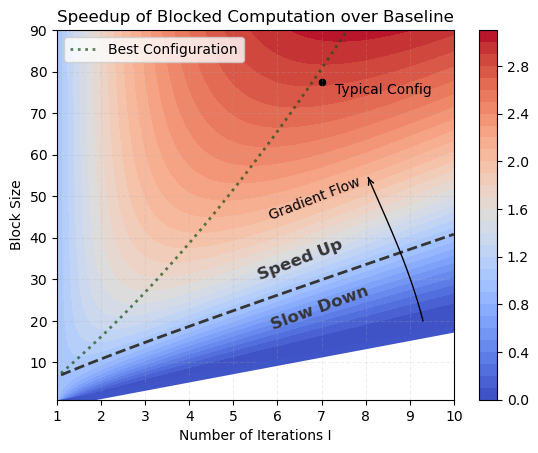

In [ ]:
lam = 1 / 12
D = 3
def speed_up(I, B):
    return ((1 - 2*(I-1)/B) ** D) / (1/I + lam * (1 - 1/I))


B_min, B_max = 1, 90
I_min, I_max = 1, 10

I, B = np.meshgrid(np.linspace(I_min, I_max, 100), np.linspace(B_min, B_max, 100))
Z = speed_up(I, B)
Z[Z < 0] = np.nan


level_step = 0.1
levels = np.arange(np.ceil(np.nanmax(Z) / level_step) + 1) * level_step
cp = plt.contourf(I, B, Z, levels=levels, cmap="coolwarm")


l3 = lam ** (1 / 3)
t = np.linspace(I_min, I_max, 100)[1:]
plt.plot(t, 2 * (t - 1) / (1 - (1 / t + lam * (1 - 1 / t)) ** (1 / 3)), color="#353535", linestyle="dashed", linewidth=2)
plt.plot(t, 2 * (t - 1), color="#4055c8", linewidth=5)

plt.plot(t, 6 / (1 / lam - 1) * t**2 + 8 * t - 2, color="#175015", linewidth=2, linestyle=":", label="Best Configuration", alpha=0.7)
plt.legend()
# plt.plot((b+2)/2, b, color="black", linestyle="dashed", linewidth=2)

# get the gradient of Z
def speed_up_grad(I, B):
    l = I * lam + 1 - lam
    c = (1 - 2 * (I - 1) / B) ** D
    dkdI = ((1 - lam) / l**2 - 2 * D * I / (B - 2 * (I - 1)) / l) * c
    dkdB = (2 * I * (I - 1) * D / (B - 2 * (I - 1)) / l / B) * c
    g = np.array([dkdI * (I_max - I_min) ** 2, dkdB * (B_max - B_min) ** 2]).T
    return g


integrator = field_integrator(
    field_fn=lambda p: speed_up_grad(p[:, 0], p[:, 1]),
    xlim=(I_min, I_max),
    ylim=(B_min, B_max),
    ds=0.05,
    max_steps=690,
)
arr, _ = integrator(9.3, 20)
plt.text(5.5, 30, "Speed Up", color="#353535", fontsize=12, weight="bold", rotation=21)
plt.text(5.8, 18, "Slow Down", color="#353535", fontsize=12, weight="bold", rotation=20)
plt.plot(arr[:, 0], arr[:, 1], color="black", linewidth=1)
plt.annotate("", xytext=(arr[-2, 0], arr[-2, 1]), xy=(arr[-1, 0], arr[-1, 1]), arrowprops=dict(arrowstyle="->", color="black"))
plt.text(arr[-1, 0] - 2.3, arr[-1, 1] - 10, "Gradient Flow", color="black", fontsize=10, rotation=21)



# Add a point
point = (7, (32 * 2 * 16 * 6 * 2 * 38) ** (1 / 3))
plt.scatter(*point, color="black", s=20)   
plt.text(point[0] + 0.3, point[1] - 3, "Typical Config", color="black", fontsize=10)

# plt.xticks(np.arange(0, 21, 2))
plt.colorbar(cp)
plt.grid(alpha=0.2, linestyle='--')
plt.xlabel("Number of Iterations I")
plt.ylabel("Block Size")
plt.xlim(I_min, I_max)
plt.ylim(B_min, B_max)
plt.title("Speedup of Blocked Computation over Baseline")
plt.show()
